# Predicting Goodreads Book Ratings vs Reviews

Goal: to predict the ratio between the number of Goodreads book ratings relative to the number of reviews for fiction books written in English

In [1]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# import statsmodels.api as sm
import statsmodels.formula.api as smf

import pickle

%matplotlib inline

In [2]:
sns.set_style('whitegrid')

## Gather Data

#### Scrape Goodreads book list

In [2]:
# helper function
def get_list_by_page(soup_obj):
    """ Scrape information from Goodreads book list."""
    books_page = []
    
    book_titles = soup_obj.find_all('a', {'class':'bookTitle'}, href=True)
    for bk in range(len(book_titles)):
        book_dict = {}
        
        book_dict['link'] = book_titles[bk]['href']
        book_dict['title'] = book_titles[bk].text.strip() # title
        book_dict['author'] = soup_obj.find_all('span', {'itemprop':'author'})[bk].text.strip().replace(' (Goodreads Author)', '')
        
        ratings = soup_obj.find_all('span', {'class':'greyText smallText uitext'})
        book_dict['avg_ratings'] = ratings[bk].text.split()[0]
        book_dict['num_ratings'] = ratings[bk].text.split()[4].replace(',', '')
        
        voters = soup_obj.find_all('span', {'class':'smallText uitext'})
        book_dict['voters_score'] = voters[bk].text.split()[1].replace(',', '')
        book_dict['num_voters'] = voters[bk].text.split()[3].replace(',', '')
        books_page.append(book_dict)
    
    return books_page

In [4]:
# scrape books in Books That Everyone Should Read At Least Once list
read_books_list = []

for pg in range(1, 180):
    page_url = f'https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page={pg}'
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text,"lxml")
    read_books_list.extend(get_list_by_page(soup))

read_books_list

# 179 pages total


In [5]:
len(read_books_list)

In [6]:
# pickled for future use
pickle.dump(read_books_list, open("./pickled/read_books_list.p", "wb"))

#### Scrape individual Goodreads book profile

In [7]:
# helper function
def get_book_info(soup_obj):
    """Scrape information from Goodreads book profiles."""
    info_dict = {}
    
    try:
        info_dict['title'] = soup_obj.find_all('h1')[0].text.strip('\n')
    except IndexError:
        info_dict['title'] = ''
    
    try:
        info_dict['author'] = soup_obj.find_all(itemprop="name")[1].text
    except IndexError:
        info_dict['author'] = ''
    
    try:
        info_dict['avg_rating'] = soup_obj.find_all(itemprop="ratingValue")[0].text
    except IndexError:
        info_dict['avg_rating'] = ''
    
    try:
        info_dict['total_ratings'] = soup_obj.find_all(itemprop="ratingCount")[0].text
    except IndexError:
        info_dict['total_ratings'] = ''
        
    try:
        info_dict['total_reviews'] = soup_obj.find_all('span', {'class':'value-title'})[1].text
    except IndexError:
        info_dict['total_reviews'] = ''
    
    try:
        info_dict['publish'] = soup_obj.find_all('div', {'class':'row'})[1].text.strip()
    except IndexError:
        info_dict['publish'] = ''
    
    try:
        gen = soup_obj.find_all('a', {'class': 'actionLinkLite bookPageGenreLink'})
        info_dict['genre_list'] = [v.text for i, v in enumerate(gen)]
    except IndexError:
        info_dict['genre_list'] = []
    
    try:
        info_dict['language'] = soup_obj.find_all(itemprop="inLanguage")[0].text
    except IndexError:
        info_dict['language'] = ''
    
    try:
        info_dict['pages'] = soup_obj.find_all(itemprop="numberOfPages")[0].text
    except IndexError:
        info_dict['pages'] = ''
        
    try:
        info_dict['awards'] = soup_obj.find_all(itemprop="awards")[0].text.strip()
    except IndexError:
        info_dict['awards'] = []

    return info_dict

In [8]:
# scrape individual book info using links
links = [l['link'] for l in read_books_list]
books_info_list = []

for lk in links:
    book_url = f'http://www.goodreads.com{lk}'
    response = requests.get(book_url)
    soup = BeautifulSoup(response.text,"lxml")
    books_info_list.append(get_book_info(soup))

books_info_list

In [9]:
len(books_info_list)

In [10]:
# pickled for future use
pickle.dump(books_info_list, open("./pickled/books_info_list.p", "wb"))

## Clean data

#### Book List

In [3]:
read_books_list = pickle.load(open('./pickled/read_books_list.p', 'rb'))
books_info_list = pickle.load(open('./pickled/books_info_list.p', 'rb'))

In [4]:
# create data frame from scraped data
read_books_df = pd.DataFrame()
read_books_df['link'] = [bk['link'] for bk in read_books_list]
read_books_df['title'] = [bk['title'] for bk in read_books_list]
read_books_df['author'] = [bk['author'] for bk in read_books_list]
read_books_df['avg_ratings'] = [bk['avg_ratings'] for bk in read_books_list]
read_books_df['num_ratings'] = [bk['num_ratings'] for bk in read_books_list]
read_books_df['voters_score'] = [bk['voters_score'] for bk in read_books_list]
read_books_df['num_voters'] = [bk['num_voters'] for bk in read_books_list]

In [5]:
# convert features to numeric
read_books_df['avg_ratings'] = pd.to_numeric(read_books_df['avg_ratings'], errors='coerce')
read_books_df['num_ratings'] = pd.to_numeric(read_books_df['num_ratings'], errors='coerce')
read_books_df['voters_score'] = pd.to_numeric(read_books_df['voters_score'], errors='coerce')
read_books_df['num_voters'] = pd.to_numeric(read_books_df['num_voters'], errors='coerce')

In [6]:
read_books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17817 entries, 0 to 17816
Data columns (total 7 columns):
link            17817 non-null object
title           17817 non-null object
author          17817 non-null object
avg_ratings     16720 non-null float64
num_ratings     16720 non-null float64
voters_score    17817 non-null int64
num_voters      17817 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 974.4+ KB


In [7]:
read_books_df.sample(5)

,link,title,author,avg_ratings,num_ratings,voters_score,num_voters
13581,/book/show/654230.Just_Another_Soldier,Just Another Soldier: A Year on the Ground in ...,Jason Christopher Hartley,3.78,161.0,85,1
9946,/book/show/25541575-please-say-kaddish-for-me,Please Say Kaddish For Me,Rochelle Wisoff-Fields,4.81,16.0,97,1
2269,/book/show/168484.Feminism_is_for_Everybody,Feminism is for Everybody: Passionate Politics,bell hooks,4.17,7710.0,367,4
11762,/book/show/25855990-grey,Grey: Fifty Shades of Grey as Told by Christia...,Bern Bolo,3.45,11.0,93,1
15985,/book/show/13536590-start-something-that-matters,Start Something That Matters,Blake Mycoskie,4.05,6678.0,62,1


#### Individual Book Profile

In [8]:
books_info_list[0].keys()

dict_keys(['title', 'author', 'avg_rating', 'total_ratings', 'total_reviews', 'publish', 'genre_list', 'language', 'pages', 'awards'])

In [9]:
# create data frame from scraped data
books_info_df = pd.DataFrame()
books_info_df['title_2'] = [bk['title'] for bk in books_info_list]
books_info_df['author_2'] = [bk['author'] for bk in books_info_list]
books_info_df['avg_ratings_2'] = [bk['avg_rating'] for bk in books_info_list]
books_info_df['num_ratings_2'] = [bk['total_ratings'] for bk in books_info_list]
books_info_df['total_reviews'] = [bk['total_reviews'] for bk in books_info_list]
books_info_df['language'] = [bk['language'] for bk in books_info_list]
books_info_df['pages'] = [bk['pages'] for bk in books_info_list]
books_info_df['publish'] = [bk['publish'] for bk in books_info_list]
books_info_df['awards'] = [bk['awards'] for bk in books_info_list]
books_info_df['genre_list'] = [bk['genre_list'] for bk in books_info_list]

In [10]:
books_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17817 entries, 0 to 17816
Data columns (total 10 columns):
title_2          17817 non-null object
author_2         17817 non-null object
avg_ratings_2    17817 non-null object
num_ratings_2    17817 non-null object
total_reviews    17817 non-null object
language         17817 non-null object
pages            17817 non-null object
publish          17817 non-null object
awards           17817 non-null object
genre_list       17817 non-null object
dtypes: object(10)
memory usage: 1.4+ MB


In [11]:
books_info_df.sample(5)

,title_2,author_2,avg_ratings_2,num_ratings_2,total_reviews,language,pages,publish,awards,genre_list
12429,God and the State,Mikhail Bakunin,3.85,"2,206 Ratings",107,,,Published\n \n \n\n \...,[],"[Philosophy, Politics, Religion, Nonfiction, C..."
370,Cloud Atlas,David Mitchell,4.01,"170,666 Ratings","16,898",English,509 pages,Published\n August 17th 2004\n ...,"Man Booker Prize Nominee (2004), Nebula Award ...","[Science Fiction, Fiction, Historical, Science..."
9579,Master Key System,Robert C. Worstell,5.0,1 Rating,0,English,,Published\n \n by Midwest Journ...,[],[]
10274,The Cosmic Serpent: DNA and the Origins ...,Jeremy Narby,4.23,"3,139 Ratings",242,English,257 pages,Published\n April 5th 1999\n by...,[],"[Science, Nonfiction, Anthropology, Spirituali..."
10198,The Winter Queen\n \n (Era...,Boris Akunin,3.86,"7,666 Ratings",620,English,256 pages,Published\n March 25th 2004\n b...,[],"[Mystery, Fiction, Historical, Cultural, Russi..."


In [12]:
# clean features
books_info_df['num_ratings_2'] = [re.sub(',| [Rr]\S*', '', i) for i in books_info_df.num_ratings_2]
books_info_df['total_reviews'] = [re.sub(',', '', i) for i in books_info_df.total_reviews]
books_info_df['pages'] = [re.sub('pages', '', i).strip() for i in books_info_df.pages]

In [13]:
# convert features to numeric
books_info_df['avg_ratings_2'] = pd.to_numeric(books_info_df['avg_ratings_2'], errors='coerce')
books_info_df['num_ratings_2'] = pd.to_numeric(books_info_df['num_ratings_2'], errors='coerce')
books_info_df['total_reviews'] = pd.to_numeric(books_info_df['total_reviews'], errors='coerce')
books_info_df['pages'] = pd.to_numeric(books_info_df['pages'], errors='coerce')

In [14]:
# extract publisher and year
years = []
publisher = []
for bk in books_info_df.publish:
    bk_lower = bk.lower()
    y = re.findall(r"([0-9][0-9][0-9][0-9])", bk_lower)
    i = bk_lower.find('by ')
    publisher.append(bk_lower[(i+3):].split('\n')[0])
    
    if y == []:
        years.append('')
    else:
        years.append(2017-int(y[-1]))

In [15]:
# extract number of awards won
num_awards = []
for bk in books_info_df.awards:
    if bk:
        num_awards.append(len(bk.replace('...more', ',').split(',')))
    else:
        num_awards.append(0)    

In [16]:
# extract genre
fiction = []
genre = []
for bk in books_info_df.genre_list:

    if 'Fiction' in bk:
        fiction.append(1)
    else:
        fiction.append(0)
        
    if not bk:
        genre.append('')
    elif 'Nonfiction' in bk:
        genre.append('Nonfiction')
    elif (len(bk)>1) & (bk[0]=='Fiction'):
        genre.append(bk[1])
    else:
        genre.append(bk[0])

In [17]:
# add features to data frame
books_info_df['publisher'] = publisher
books_info_df['years'] = pd.to_numeric(years, errors='coerce')
books_info_df['num_awards'] = pd.to_numeric(num_awards, errors='coerce')
books_info_df['fiction'] = fiction
books_info_df['genre'] = genre

In [18]:
# extract genre
fiction = []
genre = []
for bk in books_info_df.genre_list:
#     temp = [x.lower() for x in bk]
    if 'fiction' in bk:
        fiction.append(1)
    else:
        fiction.append(0)
        
    if not bk:
        genre.append('')
    elif 'Nonfiction' in bk:
        genre.append('Nonfiction')
    elif (len(bk)>1) & (bk[0]=='Fiction'):
        genre.append(bk[1])
    else:
        genre.append(bk[0])

Since were are a number of books that have 0 reviews (in `total_reviews`), I added 1 to each `total_reviews` and `num_ratings_2` to make it easier to calculate a ratio between the number of ratings and reviews (`ratings_reviews`), the dependent variable or outcome.

In [19]:
num_ratings_2 = np.add(books_info_df.num_ratings_2.copy(), 1)
total_reviews = np.add(books_info_df.total_reviews.copy(), 1)
books_info_df['ratings_reviews'] = np.divide(num_ratings_2, total_reviews)

In [20]:
# pickled for future use
pickle.dump(read_books_df, open("./pickled/read_books_df.p", "wb"))
pickle.dump(books_info_df, open("./pickled/books_info_df.p", "wb"))

#### Merge data frames

In [21]:
data = read_books_df.merge(books_info_df, left_index=True, right_index=True)

In [22]:
# pickled for future use
pickle.dump(data, open("./pickled/data.p", "wb"))

## Exploratory Data Analysis

In [6]:
data = pickle.load(open('./pickled/data.p', 'rb'))

Since my goal was to specifically look at fiction books written in English, I subsetted my data based on this criteria.

In [7]:
data.language.value_counts().head()

English    15182
            1340
Arabic       229
Spanish      188
French       108
Name: language, dtype: int64

In [8]:
data.fiction.value_counts().head()

0    9863
1    7954
Name: fiction, dtype: int64

In [9]:
eng_fiction = data[(data.language=='English') & (data.fiction==1)]

I started off by examining the outcome and features (e.g., distributions, summary statistics, outliers).

In [10]:
eng_fiction.columns

Index(['link', 'title', 'author', 'avg_ratings', 'num_ratings', 'voters_score',
       'num_voters', 'title_2', 'author_2', 'avg_ratings_2', 'num_ratings_2',
       'total_reviews', 'language', 'pages', 'publish', 'awards', 'genre_list',
       'publisher', 'years', 'num_awards', 'fiction', 'genre',
       'ratings_reviews'],
      dtype='object')

In [11]:
# keep relevant features
eng_fiction = eng_fiction[['ratings_reviews', 'num_ratings_2', 'total_reviews', 
                           'voters_score', 'num_voters', 'avg_ratings_2', 'pages', 
                           'years', 'num_awards', 'genre']]

# remove rows with missing information
eng_fiction = eng_fiction.dropna()

I noticed that 21 of the books in the data are recorded as having 0 pages. However, that is unlikely and it is probably a mistake. Thus, these values were set to NaN and removed from analysis.

In [12]:
sum(eng_fiction.pages==0)

21

In [13]:
eng_fiction.pages[eng_fiction.pages==0] = np.nan
eng_fiction = eng_fiction.dropna()

In [14]:
eng_fiction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6880 entries, 1 to 17816
Data columns (total 10 columns):
ratings_reviews    6880 non-null float64
num_ratings_2      6880 non-null float64
total_reviews      6880 non-null float64
voters_score       6880 non-null int64
num_voters         6880 non-null int64
avg_ratings_2      6880 non-null float64
pages              6880 non-null float64
years              6880 non-null float64
num_awards         6880 non-null int64
genre              6880 non-null object
dtypes: float64(6), int64(3), object(1)
memory usage: 591.2+ KB


Before fitting models, I looked at the summary statistics and distribution of the features.

In [15]:
eng_fiction.describe()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards
count,6880.000000,6.880000e+03,6880.000000,6.880000e+03,6880.000000,6880.000000,6880.000000,6880.000000,6880.000000
mean,24.292144,7.387714e+04,3137.991570,6.039327e+03,69.887791,3.957846,362.588663,37.051599,1.060756
std,46.077877,2.818310e+05,9880.192071,5.103469e+04,545.200335,0.266768,270.410617,57.184123,2.466953
min,1.000000,1.000000e+00,0.000000,0.000000e+00,-1.000000,2.470000,2.000000,0.000000,0.000000
25%,8.818003,2.133750e+03,130.000000,8.300000e+01,1.000000,3.790000,231.000000,9.000000,0.000000
50%,15.327029,9.515000e+03,548.000000,9.900000e+01,1.000000,3.970000,321.000000,19.000000,0.000000
75%,27.737821,3.887675e+04,2013.000000,2.580000e+02,3.000000,4.140000,430.000000,44.000000,1.000000
max,2463.232558,4.898669e+06,154965.000000,1.504091e+06,15345.000000,5.000000,8124.000000,1017.000000,35.000000


After examining the continuous variables, I noticed that many of the variables were skewed. Below, I log transformed the variables, and examined the variables before and after the transformation. The dotted black lines represent the median.

In [16]:
eng_fiction['ratings_reviews_log'] = np.log(eng_fiction.ratings_reviews)
eng_fiction['num_ratings_2_log'] = np.log(eng_fiction.num_ratings_2)
eng_fiction['total_reviews_log'] = np.log(eng_fiction.total_reviews + 1)
eng_fiction['voters_score_log'] = np.log(eng_fiction.voters_score + 1)
eng_fiction['pages_log'] = np.log(eng_fiction.pages + 1)
eng_fiction['years_log'] = np.log(eng_fiction.years + 1)
eng_fiction['num_awards_log'] = np.log(eng_fiction.num_awards + 1)

eng_fiction['awarded'] = [1 if x>0 else 0 for x in eng_fiction.num_awards]

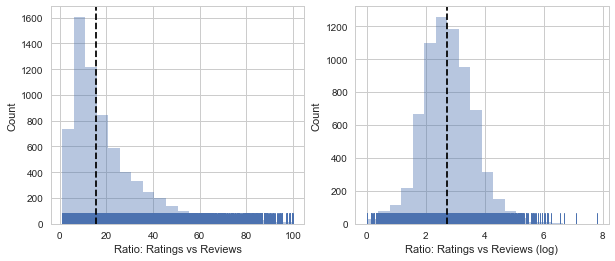

In [68]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
ax = sns.distplot(eng_fiction.ratings_reviews[eng_fiction.ratings_reviews<100], bins=20, kde=False, rug=True)
ax.set(xlabel='Ratio: Ratings vs Reviews', ylabel='Count')
plt.axvline(eng_fiction.ratings_reviews.median(), color='k', linestyle='--')

plt.subplot(1,2,2)
ax = sns.distplot(eng_fiction.ratings_reviews_log, bins=20, kde=False, rug=True)
ax.set(xlabel='Ratio: Ratings vs Reviews (log)', ylabel='Count')
plt.axvline(eng_fiction.ratings_reviews_log.median(), color='k', linestyle='--');

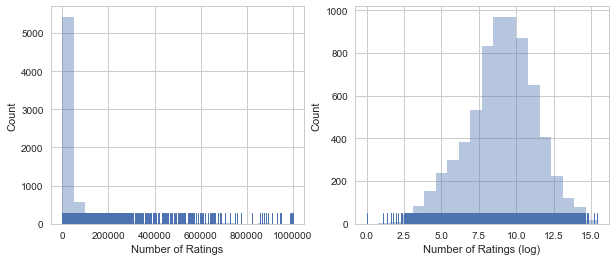

In [65]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
ax = sns.distplot(eng_fiction.num_ratings_2[eng_fiction.num_ratings_2<1e6], bins=20, kde=False, rug=True)
ax.set(xlabel='Number of Ratings', ylabel='Count')

plt.subplot(1,2,2)
ax = sns.distplot(eng_fiction.num_ratings_2_log, bins=20, kde=False, rug=True)
ax.set(xlabel='Number of Ratings (log)', ylabel='Count');

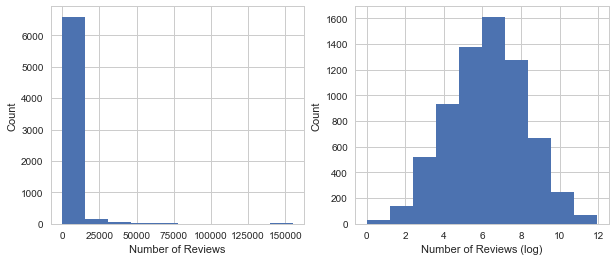

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
eng_fiction.total_reviews.hist();
plt.xlabel('Number of Reviews')
plt.ylabel('Count')

plt.subplot(1,2,2)
eng_fiction.total_reviews_log.hist()
plt.xlabel('Number of Reviews (log)')
plt.ylabel('Count');

[<matplotlib.text.Text at 0x1483d9da0>, <matplotlib.text.Text at 0x1483cc550>]

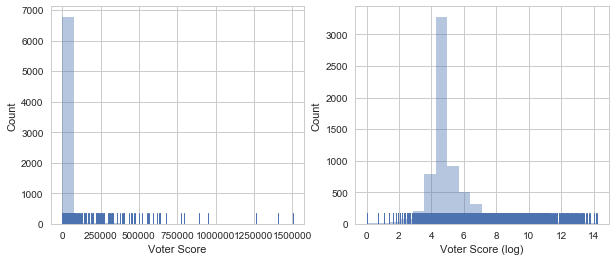

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
ax = sns.distplot(eng_fiction.voters_score, bins=20, kde=False, rug=True)
ax.set(xlabel='Voter Score', ylabel='Count')

plt.subplot(1,2,2)
ax = sns.distplot(eng_fiction.voters_score_log, bins=20, kde=False, rug=True)
ax.set(xlabel='Voter Score (log)', ylabel='Count');

[<matplotlib.text.Text at 0x15120b908>, <matplotlib.text.Text at 0x1417a4dd8>]

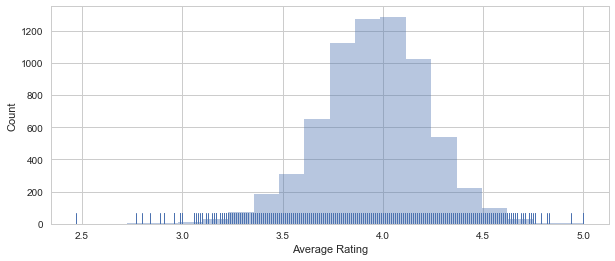

In [17]:
plt.figure(figsize=(10, 4))
ax = sns.distplot(eng_fiction.avg_ratings_2, bins=20, kde=False, rug=True)
ax.set(xlabel='Average Rating', ylabel='Count');

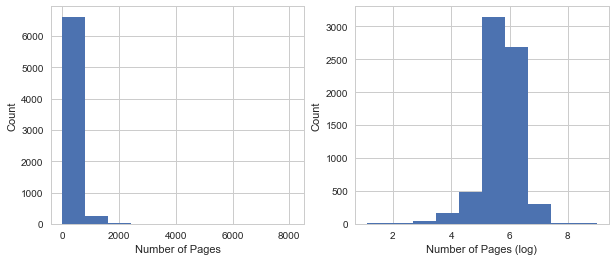

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
eng_fiction.pages.hist()
plt.xlabel('Number of Pages')
plt.ylabel('Count')

plt.subplot(1,2,2)
eng_fiction.pages_log.hist()
plt.xlabel('Number of Pages (log)')
plt.ylabel('Count');

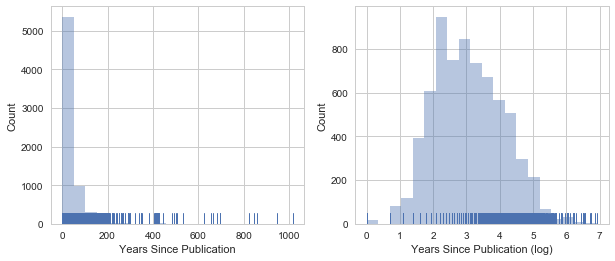

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
ax = sns.distplot(eng_fiction.years, bins=20, kde=False, rug=True)
ax.set(xlabel='Years Since Publication', ylabel='Count')

plt.subplot(1,2,2)
ax = sns.distplot(eng_fiction.years_log, bins=20, kde=False, rug=True)
ax.set(xlabel='Years Since Publication (log)', ylabel='Count');

Even after log transformation, the number of awards (`num_awards_log`) was still is skewed.

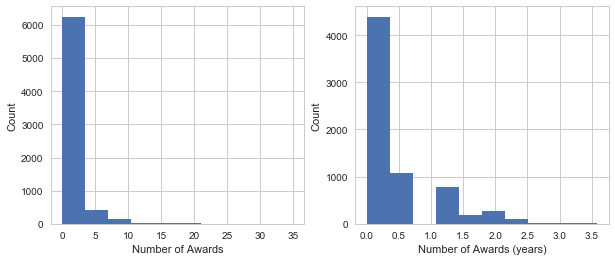

In [23]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
eng_fiction.num_awards.hist()
plt.xlabel('Number of Awards')
plt.ylabel('Count')

plt.subplot(1,2,2)
eng_fiction.num_awards_log.hist()
plt.xlabel('Number of Awards (years)')
plt.ylabel('Count');

Since most of the books did not only win any awards (i.e., 4410 books), I thought it may be useful to see if winning any awards would be an good predictor. So I created a new dummy variable.

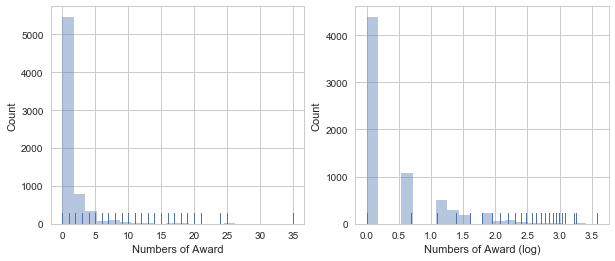

In [24]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
ax = sns.distplot(eng_fiction.num_awards, bins=20, kde=False, rug=True)
ax.set(xlabel='Numbers of Award', ylabel='Count')

plt.subplot(1,2,2)
ax = sns.distplot(eng_fiction.num_awards_log, bins=20, kde=False, rug=True)
ax.set(xlabel='Numbers of Award (log)', ylabel='Count');

For the genres, I took the top 3 genres and created dummy variables (i.e., 0 = book not in genre; and 1 = book in genre) for each of them.

In [17]:
eng_fiction.genre.value_counts().head()

Fantasy        1011
Historical      906
Classics        798
Young Adult     508
Mystery         480
Name: genre, dtype: int64

In [18]:
eng_fiction['fantasy'] = [1 if x=='Fantasy' else 0 for x in eng_fiction.genre]
eng_fiction['historical'] = [1 if x=='Historical' else 0 for x in eng_fiction.genre]
eng_fiction['classics'] = [1 if x=='Classics' else 0 for x in eng_fiction.genre]

In [19]:
eng_fiction.groupby(['fantasy']).median()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards,ratings_reviews_log,num_ratings_2_log,total_reviews_log,voters_score_log,pages_log,years_log,num_awards_log,awarded,historical,classics
fantasy,,,,,,,,,,,,,,,,,,,
0,14.851624,9212.0,550.0,99,1,3.95,318.0,20.0,0,2.698109,9.128262,6.311735,4.605170,5.765191,3.044522,0.0,0,0,0
1,18.939691,11654.0,527.0,97,1,4.04,374.0,13.0,0,2.941260,9.363405,6.269096,4.584967,5.926926,2.639057,0.0,0,0,0


In [20]:
eng_fiction.groupby(['historical']).median()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards,ratings_reviews_log,num_ratings_2_log,total_reviews_log,voters_score_log,pages_log,years_log,num_awards_log,awarded,fantasy,classics
historical,,,,,,,,,,,,,,,,,,,
0,16.446106,9717.0,526.0,98,1,3.96,318.0,19.0,0,2.800089,9.181632,6.267201,4.59512,5.765191,2.995732,0.0,0,0,0
1,10.427671,8105.5,668.5,99,1,3.99,384.0,14.0,0,2.344463,9.000297,6.506531,4.60517,5.953243,2.708050,0.0,0,0,0


In [21]:
eng_fiction.groupby(['classics']).median()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards,ratings_reviews_log,num_ratings_2_log,total_reviews_log,voters_score_log,pages_log,years_log,num_awards_log,awarded,fantasy,historical
classics,,,,,,,,,,,,,,,,,,,
0,14.130134,8396.5,498.5,98.0,1.0,3.97,323.0,16.0,0.0,2.648310,9.035570,6.213607,4.595120,5.780744,2.833213,0.0,0.0,0.0,0.0
1,24.114948,25777.0,993.0,260.5,4.0,3.94,304.0,99.0,0.0,3.182832,10.157189,6.901737,5.566432,5.720312,4.605170,0.0,0.0,0.0,0.0


In [22]:
# examine books with the highest ratio
sorted_ratings_reviews = eng_fiction.sort_values(by='ratings_reviews', ascending=False)
sorted_ratings_reviews.head()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards,genre,...,num_ratings_2_log,total_reviews_log,voters_score_log,pages_log,years_log,num_awards_log,awarded,fantasy,historical,classics
10391,2463.232558,105918.0,42.0,96,1,3.81,467.0,10.0,1,Fantasy,...,11.570420,3.761200,4.574711,6.148468,2.397895,0.693147,1,1,0,0
13252,1208.666667,3625.0,2.0,87,1,3.93,467.0,93.0,0,Classics,...,8.195610,1.098612,4.477337,6.148468,4.543295,0.000000,0,0,0,1
7739,797.625641,155536.0,194.0,99,1,4.12,224.0,21.0,0,Classics,...,11.954632,5.273000,4.605170,5.416100,3.091042,0.000000,0,0,0,1
14529,692.885057,60280.0,86.0,79,1,4.35,642.0,168.0,0,Classics,...,11.006756,4.465908,4.382027,6.466145,5.129899,0.000000,0,0,0,1
16817,524.307692,20447.0,38.0,44,1,4.07,178.0,17.0,0,Horror,...,9.925591,3.663562,3.806662,5.187386,2.890372,0.000000,0,0,0,0


In [23]:
# examine books with the lowest ratio
sorted_ratings_reviews.tail()

,ratings_reviews,num_ratings_2,total_reviews,voters_score,num_voters,avg_ratings_2,pages,years,num_awards,genre,...,num_ratings_2_log,total_reviews_log,voters_score_log,pages_log,years_log,num_awards_log,awarded,fantasy,historical,classics
10045,1.166667,20.0,17.0,97,1,4.50,229.0,2.0,0,Romance,...,2.995732,2.890372,4.584967,5.438079,1.098612,0.0,0,0,0,0
6988,1.161290,35.0,30.0,100,1,4.00,395.0,2.0,0,Fiction,...,3.555348,3.433987,4.615121,5.981414,1.098612,0.0,0,0,0,0
7427,1.153846,14.0,12.0,100,1,4.07,12.0,0.0,0,Short Stories,...,2.639057,2.564949,4.615121,2.564949,0.000000,0.0,0,0,0,0
15893,1.000000,3.0,3.0,63,1,4.67,590.0,5.0,0,Fiction,...,1.098612,1.386294,4.158883,6.381816,1.791759,0.0,0,0,0,0
7429,1.000000,1.0,1.0,100,1,5.00,219.0,2.0,0,Fiction,...,0.000000,0.693147,4.615121,5.393628,1.098612,0.0,0,0,0,0


In [24]:
# pickled for future use
pickle.dump(eng_fiction, open("./pickled/eng_fiction.p", "wb"))

## Fit Linear Regression Model

In [3]:
eng_fiction = pickle.load(open('./pickled/eng_fiction.p', 'rb'))

In [4]:
eng_fiction.columns

Index(['ratings_reviews', 'num_ratings_2', 'total_reviews', 'voters_score',
       'num_voters', 'avg_ratings_2', 'pages', 'years', 'num_awards', 'genre',
       'ratings_reviews_log', 'num_ratings_2_log', 'total_reviews_log',
       'voters_score_log', 'pages_log', 'years_log', 'num_awards_log',
       'awarded', 'fantasy', 'historical', 'classics'],
      dtype='object')

In [5]:
col_keep = ['ratings_reviews_log', 'avg_ratings_2', 'voters_score_log','pages_log', 'years_log', 
            'num_awards_log','awarded', 'fantasy', 'historical', 'classics']
eng_fiction_col = eng_fiction[col_keep]

I examined the relationship between the features and dependent variable.

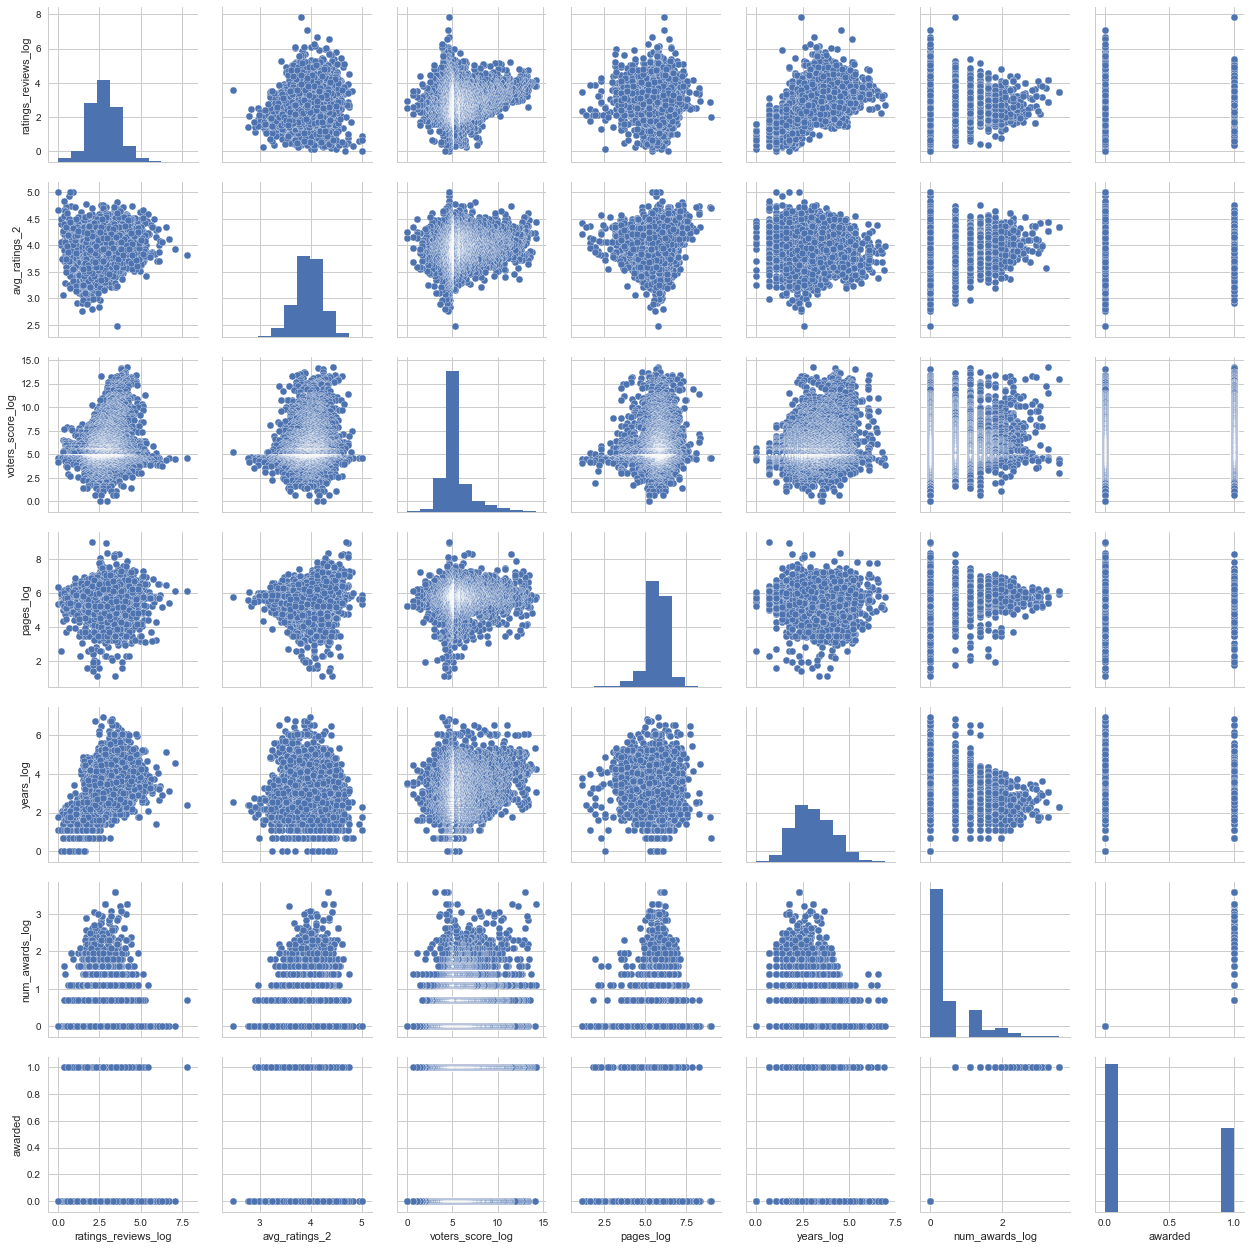

In [46]:
# visually explore the relationships between the features (except genres)
eng_fiction_col_pp = eng_fiction_col.iloc[:,:7]
sns.pairplot(eng_fiction_col_pp)

From the correlation matrix, I could see that the number of awards received (`total_awards_log`) and whether of not an award was given (`awarded`) were highly correlated. If both of these features were included in the same linear regression model, there may be multicollinearity issues.

In [6]:
cor_matrix = eng_fiction_col.corr()
cor_matrix

,ratings_reviews_log,avg_ratings_2,voters_score_log,pages_log,years_log,num_awards_log,awarded,fantasy,historical,classics
ratings_reviews_log,1.000000,0.195503,0.219948,0.013925,0.499689,-0.073479,-0.075670,0.098366,-0.164766,0.194365
avg_ratings_2,0.195503,1.000000,0.128775,0.094282,0.036599,0.056392,0.028601,0.121193,0.032279,-0.027365
voters_score_log,0.219948,0.128775,1.000000,0.059928,0.215083,0.218754,0.180940,-0.042529,-0.001030,0.268514
pages_log,0.013925,0.094282,0.059928,1.000000,-0.140882,0.081832,0.081914,0.121900,0.152278,-0.015783
years_log,0.499689,0.036599,0.215083,-0.140882,1.000000,-0.180409,-0.136570,-0.137796,-0.102570,0.513957
num_awards_log,-0.073479,0.056392,0.218754,0.081832,-0.180409,1.000000,0.861152,0.019036,0.087098,-0.107960
awarded,-0.075670,0.028601,0.180940,0.081914,-0.136570,0.861152,1.000000,0.002046,0.083526,-0.080849
fantasy,0.098366,0.121193,-0.042529,0.121900,-0.137796,0.019036,0.002046,1.000000,-0.161631,-0.150339
historical,-0.164766,0.032279,-0.001030,0.152278,-0.102570,0.087098,0.083526,-0.161631,1.000000,-0.141062
classics,0.194365,-0.027365,0.268514,-0.015783,0.513957,-0.107960,-0.080849,-0.150339,-0.141062,1.000000


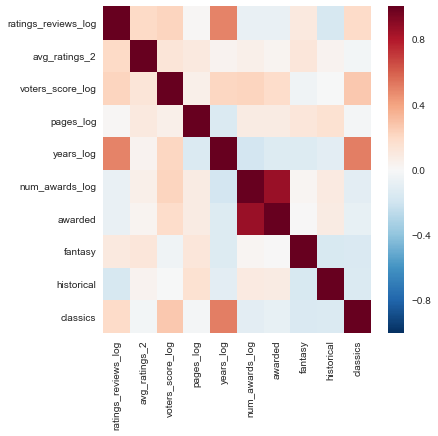

In [7]:
# visualization of the correlation matrix above
plt.figure(figsize=(6,6))
sns.heatmap(cor_matrix);

As a first step, I created a linear regression model with all of the features included. This model also used cross-validation. I quickly noticed that the feature `num_awards_log` was not a statistically significant predictor in the model.

In [8]:
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=227)
scores = cross_val_score(LinearRegression(), eng_fiction_col.iloc[:,1:], eng_fiction_col.iloc[:,0], cv=cross_valiator)
scores

array([ 0.34022468,  0.37080596,  0.30921591,  0.3368044 ,  0.30036342])

In [9]:
np.round(np.median(scores), 2)

0.34000000000000002

In [10]:
iv = '+'.join(eng_fiction_col.columns[1:])
lm1 = smf.ols('ratings_reviews_log ~ ' + iv, data=eng_fiction_col)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ratings_reviews_log   R-squared:                       0.335
Model:                             OLS   Adj. R-squared:                  0.334
Method:                  Least Squares   F-statistic:                     384.6
Date:                 Mon, 24 Jul 2017   Prob (F-statistic):               0.00
Time:                         08:50:43   Log-Likelihood:                -7385.6
No. Observations:                 6880   AIC:                         1.479e+04
Df Residuals:                     6870   BIC:                         1.486e+04
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2062      0.147     -8.227      0.000      -1.494      -0.919
avg_ratings_2        0.4565      0.033     13.916      0.000       0.392       0.521
voters_score_log     0.0617      0.006     11.165      0.000       0.051       0.073
pages_log            0.0981      0.014      7.220      0.000       0.071       0.125
years_log            0.4379      0.010     45.068      0.000       0.419       0.457
num_awards_log       0.0416      0.026      1.588      0.112      -0.010       0.093
awarded             -0.1092      0.035     -3.115      0.002      -0.178      -0.040
fantasy              0.2820      0.025     11.118      0.000       0.232       0.332
historical          -0.3081      0.026    -11.638      0.000      -0.360      -0.256
classics            -0.2977      0.032     -9.210      0.000      -0.361      -0.234
==============================================================================
Omnibus:                      591.231   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1513.463
Skew:                           0.501   Prob(JB):                         0.00
Kurtosis:                       5.068   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As previously noted, the number of awards received (`num_awards_log`) and whether or not an award received (`awarded`) were highly correlated. Since `num_awards_log` was not a statistically significant, I tried removing `num_awards_log` and re-running the linear regression model to see if this would change my R-squared. Both linear models performed similarly (R-squared and adjusted R-squared).

In [11]:
col_keep2 = ['ratings_reviews_log', 'avg_ratings_2','voters_score_log', 'pages_log', 'years_log', 
             'awarded','fantasy', 'historical', 'classics']
eng_fiction_col2 = eng_fiction_col[col_keep2]
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=227)
scores = cross_val_score(LinearRegression(), eng_fiction_col2.iloc[:,1:], eng_fiction_col2.iloc[:,0], cv=cross_valiator)
scores

array([ 0.34000035,  0.37059386,  0.3084972 ,  0.33725764,  0.30031245])

In [12]:
np.round(np.median(scores), 2)

0.34000000000000002

In [13]:
iv = '+'.join(eng_fiction_col2.columns[1:])
lm1 = smf.ols('ratings_reviews_log ~ ' + iv, data=eng_fiction_col2)
fit2 = lm1.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ratings_reviews_log   R-squared:                       0.335
Model:                             OLS   Adj. R-squared:                  0.334
Method:                  Least Squares   F-statistic:                     432.2
Date:                 Mon, 24 Jul 2017   Prob (F-statistic):               0.00
Time:                         08:50:51   Log-Likelihood:                -7386.9
No. Observations:                 6880   AIC:                         1.479e+04
Df Residuals:                     6871   BIC:                         1.485e+04
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2149      0.147     -8.291      0.000      -1.502      -0.928
avg_ratings_2        0.4589      0.033     13.999      0.000       0.395       0.523
voters_score_log     0.0631      0.005     11.574      0.000       0.052       0.074
pages_log            0.0979      0.014      7.200      0.000       0.071       0.124
years_log            0.4361      0.010     45.208      0.000       0.417       0.455
awarded             -0.0619      0.018     -3.351      0.001      -0.098      -0.026
fantasy              0.2825      0.025     11.138      0.000       0.233       0.332
historical          -0.3074      0.026    -11.613      0.000      -0.359      -0.256
classics            -0.2997      0.032     -9.280      0.000      -0.363      -0.236
==============================================================================
Omnibus:                      587.346   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1504.512
Skew:                           0.497   Prob(JB):                         0.00
Kurtosis:                       5.064   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I also tried to find a more parsimonious model, by removing `awarded` because it had a lower t-statistic compared to the other features, and examining the R-squared values. In this model, the R-squared (with cross-validation) was slightly lower than the previous model. Thus, I selected the previous model (see above) to be the final linear regression model.

In [14]:
col_keep3 = ['ratings_reviews_log', 'avg_ratings_2','voters_score_log', 'pages_log', 'years_log', 
             'fantasy', 'historical', 'classics']
eng_fiction_col3 = eng_fiction_col[col_keep3]
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=124)
scores = cross_val_score(LinearRegression(), eng_fiction_col3.iloc[:,1:], eng_fiction_col3.iloc[:,0], cv=cross_valiator)
scores

array([ 0.32642851,  0.32535262,  0.32329143,  0.29426238,  0.37171255])

In [15]:
np.round(np.median(scores), 2)

0.33000000000000002

In [16]:
iv = '+'.join(eng_fiction_col3.columns[1:])
lm1 = smf.ols('ratings_reviews_log ~ ' + iv, data=eng_fiction_col3)
fit3 = lm1.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ratings_reviews_log   R-squared:                       0.334
Model:                             OLS   Adj. R-squared:                  0.333
Method:                  Least Squares   F-statistic:                     491.6
Date:                 Mon, 24 Jul 2017   Prob (F-statistic):               0.00
Time:                         08:50:57   Log-Likelihood:                -7392.5
No. Observations:                 6880   AIC:                         1.480e+04
Df Residuals:                     6872   BIC:                         1.486e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2188      0.147     -8.312      0.000      -1.506      -0.931
avg_ratings_2        0.4589      0.033     13.991      0.000       0.395       0.523
voters_score_log     0.0592      0.005     11.103      0.000       0.049       0.070
pages_log            0.0960      0.014      7.064      0.000       0.069       0.123
years_log            0.4401      0.010     45.952      0.000       0.421       0.459
fantasy              0.2837      0.025     11.177      0.000       0.234       0.333
historical          -0.3120      0.026    -11.792      0.000      -0.364      -0.260
classics            -0.2940      0.032     -9.109      0.000      -0.357      -0.231
==============================================================================
Omnibus:                      614.953   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1530.444
Skew:                           0.528   Prob(JB):                         0.00
Kurtosis:                       5.055   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

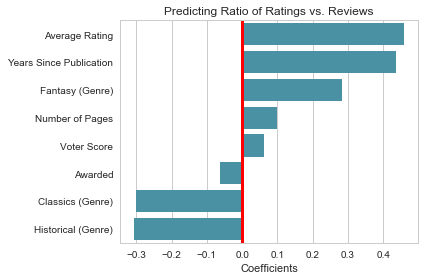

In [106]:
# plot the coefficients from the linear regression model
coeff = fit2.params.reset_index().iloc[1:,:]
coeff.columns = ['features', 'coeff']
coeff.sort_values(by='coeff', ascending=False, inplace=True)

ax = sns.barplot(x='coeff', y='features', data=coeff, color="#3B9AB2")
ax.set_title('Predicting Ratio of Ratings vs. Reviews')
ax.set(xlabel='Coefficients', ylabel='',
       yticklabels=['Average Rating', 'Years Since Publication', 'Fantasy (Genre)', 'Number of Pages', 'Voter Score', 'Awarded', 
                    'Classics (Genre)', 'Historical (Genre)'])
plt.axvline(x=0.0, color='r', linewidth=3.0)
plt.tight_layout();
plt.savefig('coefficients.png', dpi=900)

Based on the predicted vs. observed values plot below, I can see that there are some similarities between the predicted and observed values. Many points are clustered around the black line forming a cloud-like shape. However, there are a number of points that extend away from the blue cloud, indicating that the model was not able to predict these points well.

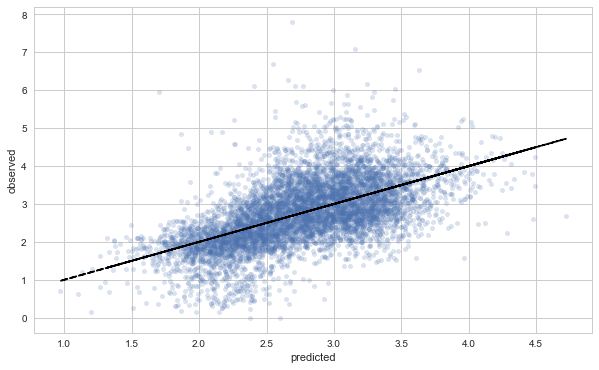

In [18]:
model = pd.DataFrame()
model['predicted'] = fit2.predict(eng_fiction_col2.iloc[:,1:])
model['observed'] = eng_fiction_col2.iloc[:,0]

ax = model.plot(kind='scatter', x='predicted', y='observed', alpha=0.2, figsize=(10,6))
ax.plot(model.predicted, model.predicted, color='k', linestyle='--');

In [19]:
# correlation between predicted and observed values
model.corr()

,predicted,observed
predicted,1.000000,0.578589
observed,0.578589,1.000000


The predicted values vs residual plot below shows that there likely isn't a problem with heteroskedasticity.

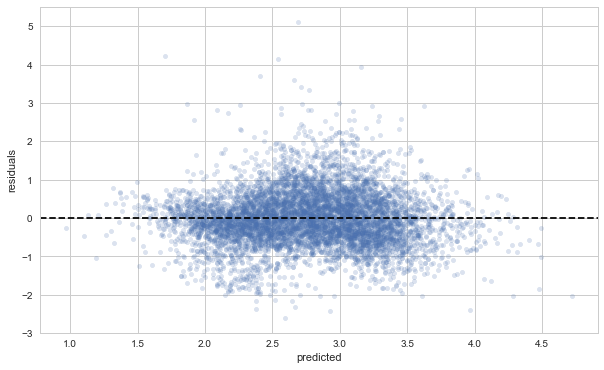

In [21]:
model = pd.DataFrame()
model['predicted'] = fit2.predict(eng_fiction_col2.iloc[:,1:])
model['residuals'] = eng_fiction_col2.iloc[:,0] - model.predicted
()
ax = model.plot(kind='scatter', x='predicted', y='residuals', alpha=0.2, figsize=(10,6))
ax.axhline(0, color='k', linestyle='--');

In [37]:
np.round(model.residuals.mean(),2)

-0.0

In [39]:
np.round(model.residuals.std(),2)

0.70999999999999996